## COMP5623 Coursework on Image Classification with Convolutional Neural Networks 

Starter code.

In [0]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
from  torch.utils.data import Dataset

from sklearn.metrics import confusion_matrix
from skimage import io, transform

import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import csv
import os
import math
import cv2

### Filter Visualization

The first part of the assignment is to build a CNN and train it on a subset of the ImageNet dataset. We will first create a dataframe with all the references to the images and their labels.

To download the images into your work environment, clone into a git respository containing the images.

In [3]:
! git clone https://github.com/MohammedAlghamdi/imagenet10.git

fatal: destination path 'imagenet10' already exists and is not an empty directory.


Check that the repository is there:

In [4]:
! ls

imagenet10  sample_data


In [0]:
root_dir = "imagenet10/train_set/"
class_names = [
  "baboon",
  "banana",
  "canoe",
  "cat",
  "desk",
  "drill",
  "dumbbell",
  "football",
  "mug",
  "orange",
]

A helper function for reading in images and assigning labels.

In [0]:
def get_meta(root_dir, dirs):
    paths, classes = [], []
    for i, dir_ in enumerate(dirs):
        for entry in os.scandir(root_dir + dir_):
            if (entry.is_file()):
                paths.append(entry.path)
                classes.append(i)
                
    return paths, classes

Now we create a dataframe using all the data.

In [0]:

paths, classes = get_meta(root_dir, class_names)

data = {
    'path': paths,
    'class': classes
}

data_df = pd.DataFrame(data, columns=['path', 'class'])
data_df = data_df.sample(frac=1).reset_index(drop=True) # that shuffles the data

View some sample data.

In [8]:
print("Found", len(data_df), "images.")
data_df.head()

Found 9000 images.


,path,class
0,imagenet10/train_set/banana/n07753592_787.JPEG,1
1,imagenet10/train_set/drill/n03239726_1895.JPEG,5
2,imagenet10/train_set/mug/n03797390_7000.JPEG,8
3,imagenet10/train_set/baboon/n02486410_3255.JPEG,0
4,imagenet10/train_set/baboon/n02486410_3715.JPEG,0


Now we will create the Dataset class.

In [0]:
class ImageNet10(Dataset):
    """ ImageNet10 dataset. """

    def __init__(self, df, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images
            df (DataFrame object): Dataframe containing the images, paths and classes
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        x = Image.open(self.df['path'][index])
        try:
          x = x.convert('RGB') 
        except:
          pass
        y = torch.tensor(int(self.df['class'][index]))

        if self.transform:
            x = self.transform(x)

        return x, y

Compute what we should normalise the dataset to.

In [0]:
def compute_img_mean_std(image_paths):

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means, stdevs


In [0]:
# saving mean and std as variable to save time
norm_mean = [0.5228375, 0.4798797, 0.40604797]
norm_std = [0.2977067, 0.28883943, 0.31178203]

We now create the transforms to normalise and turn our data into tensors.

In [0]:
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

Splitting data  into training, validation and test set.

In [0]:
train_split = 0.70 # Defines the ratio of train/valid/test data.
valid_split = 0.10

train_size = int(len(data_df)*train_split)
valid_size = int(len(data_df)*valid_split)

ins_dataset_train = ImageNet10(
    df=data_df[:train_size],
    transform=data_transform,
)

ins_dataset_valid = ImageNet10(
    df=data_df[train_size:(train_size + valid_size)].reset_index(drop=True),
    transform=data_transform,
)

ins_dataset_test = ImageNet10(
    df=data_df[(train_size + valid_size):].reset_index(drop=True),
    transform=data_transform,
)

In [0]:
train_loader = torch.utils.data.DataLoader(
    ins_dataset_train,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

valid_loader = torch.utils.data.DataLoader(
    ins_dataset_valid,
    batch_size=24, 
    shuffle=False,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    ins_dataset_test,
    batch_size=24, 
    shuffle=False,
    num_workers=2
)

classes = np.arange(0, 10)
#len(train_loader)



ConvNet model: Experiments with number of layers, kernel size.

In [0]:
# Convolutional neural network
class ConvNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
  
        # Add network layers here
        self.layer1 = nn.Conv2d(3, 16, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
           

        #Second cnn sequence
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 24, kernel_size=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.3))

        #third cnn sequence
        self.layer3 = nn.Sequential(
            nn.Conv2d(24, 32, kernel_size=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.3))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(32,40 , kernel_size=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.3))
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(40, 48, kernel_size=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.3))


        # Fully connected layers

        self.fc1 = nn.Linear(1200, 256)         
        self.fc2 = nn.Linear(256, num_classes)
         

    def forward(self, x):

        x = self.pool(torch.nn.functional.relu(self.layer1(x)))      
        x = torch.nn.functional.dropout(x, p=0.3)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)


        return x

In [0]:
from torch import optim

criterion = nn.CrossEntropyLoss()


In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

In [0]:
model_gpu = ConvNet().to(device)

optimizer = optim.SGD(model_gpu.parameters(), lr=0.001, momentum=0.9)

FILTERS VISUALISATION

In [0]:
def normalise_filters(img):
    img = img - img.min()
    img = img / img.max()
    return img

def filter_visualization():
    filters = model_gpu.layer1.weight.data
    filters = filters.to("cpu")
    filterNP = filters.numpy()

    filterNumber = 4
    picID = 1
    for k in range(0, 16):
      graph = plt.subplot(filterNumber, 4, k+1)
      graph.set_xticks([])
      graph.set_yticks([])
      #normalise filters
      plt.imshow(normalise_filters(np.clip(filters[k],0,1)[:,:,0]), cmap='gray') #Red
    plt.show()
    print("Red") 

    for k in range(0, 16):
      graph = plt.subplot(filterNumber, 4, k+1)
      graph.set_xticks([])
      graph.set_yticks([])
      plt.imshow(normalise_filters(np.clip(filters[k],0,1)[:,:,1]), cmap='gray') #Green
    plt.show()
    print("Green")

    for k in range(0, 16):
      graph = plt.subplot(filterNumber, 4, k+1)
      graph.set_xticks([])
      graph.set_yticks([])
      plt.imshow(normalise_filters(np.clip(filters[k],0,1)[:,:,2]), cmap='gray') #Blue
    plt.show()
    print("Blue")

Training function that enables to visualise filters before training, during and after training using the function above.

In [0]:
def train_model_epochs(num_epochs):
    
    train_losses=[]
    valid_losses=[]
    for epoch in range(num_epochs):

        if(epoch == 0):
            print("Filter Visualization before training")
            filter_visualization()

        running_loss = 0.0  #calculates overal batch loss for each epoch
        batch_count1 = 0    # how many time it runs over train_loader

        for i, data in enumerate(train_loader, 0):
            images, labels = data

            # Explicitly specifies that data is to be copied onto the device!
            images = images.to(device)  # <----------- And note it's NOT an in-place operation; original
            labels = labels.to(device)  # <----------- variables still exist on CPU

            optimizer.zero_grad()
            outputs = model_gpu(images) #produces the model

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()
            running_loss += loss.item()
            batch_count1 +=1
            
        print("Training loss for Epoch ", epoch+1, ", is ", running_loss/batch_count1)
        train_losses.append(running_loss/batch_count1)


        running_val_loss = 0.0
        batch_count2 = 0

        with torch.no_grad():
          for b, vdata in enumerate(valid_loader, 0):
          
            images, labels = vdata
            images = images.to(device)  # 
            labels = labels.to(device)  # 

            outputs = model_gpu(images)

            # Compute the loss based on the true labels
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()
            batch_count2 +=1

        print("Validation loss for Epoch ", epoch+1, ", is ", running_val_loss/batch_count2)
        valid_losses.append(running_val_loss/batch_count2)


        if((epoch+1)==(num_epochs//2)):
            print("Filter Visualization during training")
            filter_visualization()

        if(epoch==(num_epochs-1)):
            print("Filter Visualization after training")
            filter_visualization()

    plt.plot(train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.ylabel('Loss')
    plt.xlabel('Number of Epochs')
    plt.ylim(0, 4)
    plt.show()      


In [0]:
train_model_epochs(30)

In [22]:
correct = 0
total = 0

with torch.no_grad():
    
    all_preds = []
    all_labs = []

    # Iterate over the test set
    for data in test_loader:
        images, labels = data
        all_labs.extend(labels)

        images = images.to(device)  
        labels = labels.to(device)  
        
        outputs = model_gpu(images)
                

        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().detach().clone().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

cm = confusion_matrix(all_labs, all_preds)

Accuracy of the network on the test images: 55 %


Function to plot confusion matrix.

In [0]:
import itertools

def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    # Specify the tick marks and axis text
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    # The data formatting
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Print the text of the matrix, adjusting text colour for display
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

Confusion matrix, without normalization


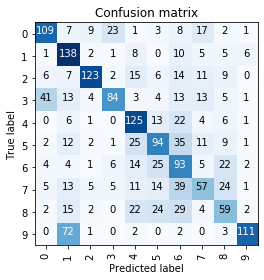

In [24]:
plot_confusion_matrix(cm, classes)

Feature maps visualisation.

In [0]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model_gpu, input, output):
        activation[name] = output.detach()
    return hook


# 1st layer feature map picture 1
model_gpu.layer1.register_forward_hook(get_activation('layer1'))
data, _ = ins_dataset_train[0]
data.unsqueeze_(0)
output = model_gpu.cpu()
output = output(data)


act = activation['layer1'].squeeze()
fig, axarr = plt.subplots(2,2)
for idx in range(act.size(0)):
  axarr[0,0].imshow(act[0], cmap='gray')
  axarr[0,1].imshow(act[1], cmap='gray')
  axarr[1,0].imshow(act[2], cmap='gray')
  axarr[1,1].imshow(act[3], cmap='gray')
fig.suptitle('Feature map layer 1')



# 2nd layer feature map picture 1
model_gpu.layer2.register_forward_hook(get_activation('layer2'))
data, _ = ins_dataset_train[0]
data.unsqueeze_(0)
output = model_gpu.cpu()
output = output(data)


act = activation['layer2'].squeeze()
fig, axarr = plt.subplots(2,2)
for idx in range(act.size(0)):
  axarr[0,0].imshow(act[0], cmap='gray')
  axarr[0,1].imshow(act[1], cmap='gray')
  axarr[1,0].imshow(act[2], cmap='gray')
  axarr[1,1].imshow(act[3], cmap='gray')
fig.suptitle('Feature map layer 2')


# 3rd layer feature map picture 1
model_gpu.layer3.register_forward_hook(get_activation('layer3'))
data, _ = ins_dataset_train[0]
data.unsqueeze_(0)
output = model_gpu.cpu()
output = output(data)


act = activation['layer3'].squeeze()
fig, axarr = plt.subplots(2,2)
for idx in range(act.size(0)):
    axarr[0,0].imshow(act[0], cmap='gray')
    axarr[0,1].imshow(act[1], cmap='gray')
    axarr[1,0].imshow(act[2], cmap='gray')
    axarr[1,1].imshow(act[3], cmap='gray')
fig.suptitle('Feature map layer 3')

# 4rth layer feature map picture 1
model_gpu.layer4.register_forward_hook(get_activation('layer4'))
data, _ = ins_dataset_train[0]
data.unsqueeze_(0)
output = model_gpu.cpu()
output = output(data)


act = activation['layer4'].squeeze()
fig, axarr = plt.subplots(2,2)
for idx in range(act.size(0)):
    axarr[0,0].imshow(act[0], cmap='gray')
    axarr[0,1].imshow(act[1], cmap='gray')
    axarr[1,0].imshow(act[2], cmap='gray')
    axarr[1,1].imshow(act[3], cmap='gray')
fig.suptitle('Feature map layer 4')

# 5th layer feature map picture 1
model_gpu.layer5.register_forward_hook(get_activation('layer5'))
data, _ = ins_dataset_train[0]
data.unsqueeze_(0)
output = model_gpu.cpu()
output = output(data)


act = activation['layer4'].squeeze()
fig, axarr = plt.subplots(2,2)
for idx in range(act.size(0)):
    axarr[0,0].imshow(act[0], cmap='gray')
    axarr[0,1].imshow(act[1], cmap='gray')
    axarr[1,0].imshow(act[2], cmap='gray')
    axarr[1,1].imshow(act[3], cmap='gray')
fig.suptitle('Feature map layer 5')
###############################################################################
 picture 2

# 1st layer feature map picture 2
model_gpu.layer1.register_forward_hook(get_activation('layer1'))
data, _ = ins_dataset_train[1]
data.unsqueeze_(0)
output = model_gpu.cpu()
output = output(data)


act = activation['layer1'].squeeze()
fig, axarr = plt.subplots(2,2)
for idx in range(act.size(0)):
    axarr[0,0].imshow(act[0], cmap='gray')
    axarr[0,1].imshow(act[1], cmap='gray')
    axarr[1,0].imshow(act[2], cmap='gray')
    axarr[1,1].imshow(act[3], cmap='gray')
fig.suptitle('Feature map layer 1')

# 2nd layer feature map picture 2
model_gpu.layer2.register_forward_hook(get_activation('layer2'))
data, _ = ins_dataset_train[3]
data.unsqueeze_(0)
output = model_gpu.cpu()
output = output(data)


act = activation['layer2'].squeeze()
fig, axarr = plt.subplots(2,2)
for idx in range(act.size(0)):
    axarr[0,0].imshow(act[0], cmap='gray')
    axarr[0,1].imshow(act[1], cmap='gray')
    axarr[1,0].imshow(act[2], cmap='gray')
    axarr[1,1].imshow(act[3], cmap='gray')
fig.suptitle('Feature map layer 2')

# 3rd layer feature map picture 2
model_gpu.layer3.register_forward_hook(get_activation('layer3'))
data, _ = ins_dataset_train[3]
data.unsqueeze_(0)
output = model_gpu.cpu()
output = output(data)


act = activation['layer3'].squeeze()
fig, axarr = plt.subplots(2,2)
for idx in range(act.size(0)):
    axarr[0,0].imshow(act[0], cmap='gray')
    axarr[0,1].imshow(act[1], cmap='gray')
    axarr[1,0].imshow(act[2], cmap='gray')
    axarr[1,1].imshow(act[3], cmap='gray')
fig.suptitle('Feature map layer 3')

# 4rth layer feature map picture 2
model_gpu.layer4.register_forward_hook(get_activation('layer4'))
data, _ = ins_dataset_train[3]
data.unsqueeze_(0)
output = model_gpu.cpu()
output = output(data)


act = activation['layer4'].squeeze()
fig, axarr = plt.subplots(2,2)
for idx in range(act.size(0)):
    axarr[0,0].imshow(act[0], cmap='gray')
    axarr[0,1].imshow(act[1], cmap='gray')
    axarr[1,0].imshow(act[2], cmap='gray')
    axarr[1,1].imshow(act[3], cmap='gray')
fig.suptitle('Feature map layer 4')

# 5th layer feature map picture 2
model_gpu.layer5.register_forward_hook(get_activation('layer5'))
data, _ = ins_dataset_train[4]
data.unsqueeze_(0)
output = model_gpu.cpu()
output = output(data)


act = activation['layer4'].squeeze()
fig, axarr = plt.subplots(2,2)
for idx in range(act.size(0)):
    axarr[0,0].imshow(act[0], cmap='gray')
    axarr[0,1].imshow(act[1], cmap='gray')
    axarr[1,0].imshow(act[2], cmap='gray')
    axarr[1,1].imshow(act[3], cmap='gray')
fig.suptitle('Feature map layer 5')

